In [1]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from data_fetching import fetch_inmet_data
from regression_pipeline import preprocess_data, train_and_evaluate_model, impute_missing_values, run_pipeline

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Composição do dataset

In [3]:
df_meta_dados = pd.read_csv('../dados/meta_dados_estacoes_2023.csv')
df_meta_dados.head()

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
0,2023,4,2023-04-09,03:00:00,A340,1.8,997.9,998.7,997.8,NaN,...,24.3,24.1,24.1,23.6,99.0,96.0,99.0,287.0,4.2,1.9
1,2023,4,2023-04-09,12:00:00,A367,0.0,987.0,987.3,986.6,415.8,...,23.2,22.3,23.0,22.2,99.0,99.0,99.0,244.0,5.0,1.2
2,2023,4,2023-04-09,00:00:00,A308,0.0,1007.1,1007.1,1006.4,0.0,...,25.1,24.7,24.8,24.6,99.0,99.0,99.0,133.0,3.8,1.9
3,2023,12,2023-12-21,15:00:00,A369,0.0,989.2,990.4,989.2,2249.1,...,31.7,28.4,31.7,30.0,100.0,99.0,99.0,NaN,NaN,NaN
4,2023,12,2023-12-21,18:00:00,A453,0.0,981.8,982.4,981.8,200.0,...,24.1,23.8,23.9,23.6,99.0,98.0,99.0,149.0,6.3,3.2


In [4]:
df_meta_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733824 entries, 0 to 733823
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ano                       733824 non-null  int64  
 1   mes                       733824 non-null  int64  
 2   data                      733824 non-null  object 
 3   hora                      733824 non-null  object 
 4   id_estacao                733824 non-null  object 
 5   precipitacao_total        510665 non-null  float64
 6   pressao_atm_hora          588148 non-null  float64
 7   pressao_atm_max           587454 non-null  float64
 8   pressao_atm_min           587451 non-null  float64
 9   radiacao_global           339095 non-null  float64
 10  temperatura_bulbo_hora    585996 non-null  float64
 11  temperatura_orvalho_hora  551192 non-null  float64
 12  temperatura_max           585332 non-null  float64
 13  temperatura_min           585328 non-null  f

Temos uma quantidade muito grande de valores nulos, vamos criar um modelo para tentar inferir esses valores

In [5]:
df_meta_dados.isnull().sum()

ano                              0
mes                              0
data                             0
hora                             0
id_estacao                       0
precipitacao_total          223159
pressao_atm_hora            145676
pressao_atm_max             146370
pressao_atm_min             146373
radiacao_global             394729
temperatura_bulbo_hora      147828
temperatura_orvalho_hora    182632
temperatura_max             148492
temperatura_min             148496
temperatura_orvalho_max     184453
temperatura_orvalho_min     184468
umidade_rel_max             176355
umidade_rel_min             176080
umidade_rel_hora            174502
vento_direcao               184662
vento_rajada_max            185800
vento_velocidade            179944
dtype: int64

In [6]:
df_meta_dados.head()

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
0,2023,4,2023-04-09,03:00:00,A340,1.8,997.9,998.7,997.8,NaN,...,24.3,24.1,24.1,23.6,99.0,96.0,99.0,287.0,4.2,1.9
1,2023,4,2023-04-09,12:00:00,A367,0.0,987.0,987.3,986.6,415.8,...,23.2,22.3,23.0,22.2,99.0,99.0,99.0,244.0,5.0,1.2
2,2023,4,2023-04-09,00:00:00,A308,0.0,1007.1,1007.1,1006.4,0.0,...,25.1,24.7,24.8,24.6,99.0,99.0,99.0,133.0,3.8,1.9
3,2023,12,2023-12-21,15:00:00,A369,0.0,989.2,990.4,989.2,2249.1,...,31.7,28.4,31.7,30.0,100.0,99.0,99.0,NaN,NaN,NaN
4,2023,12,2023-12-21,18:00:00,A453,0.0,981.8,982.4,981.8,200.0,...,24.1,23.8,23.9,23.6,99.0,98.0,99.0,149.0,6.3,3.2


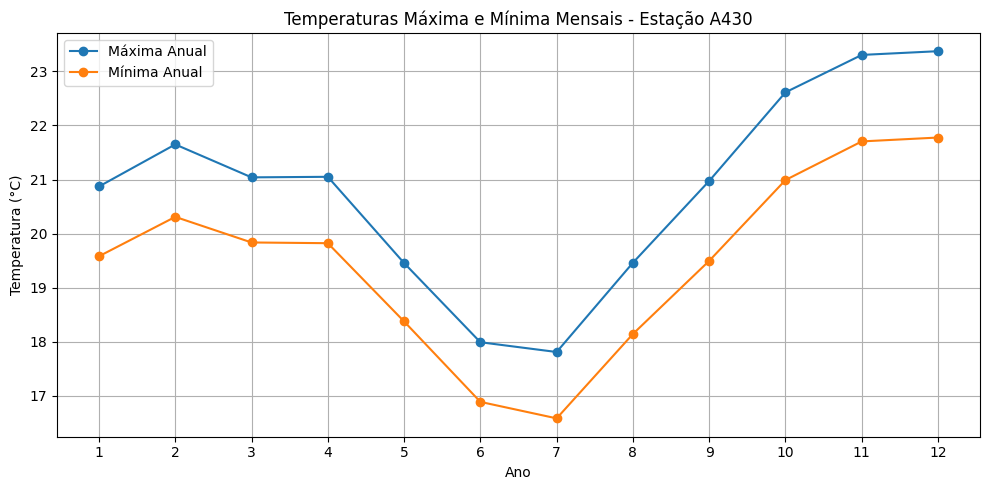

In [7]:
# Filtrar os dados apenas para a estação A305
dados_A305 = df_meta_dados[df_meta_dados['id_estacao'] == 'A430']

# Agrupar por ano e calcular a temperatura máxima e mínima anual
temperatura_anual = dados_A305.groupby('mes').agg(
    temperatura_max=('temperatura_max', 'mean'),
    temperatura_min=('temperatura_min', 'mean')
).reset_index()

# Plotar a série temporal anual
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['mes'], temperatura_anual['temperatura_max'], label='Máxima Anual', marker='o')
plt.plot(temperatura_anual['mes'], temperatura_anual['temperatura_min'], label='Mínima Anual', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Mensais - Estação A430')
plt.xticks(range(temperatura_anual['mes'].min(), temperatura_anual['mes'].max() + 1))  # Define os ticks do eixo x para cada ano
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Pré-processamento dos dados

In [8]:
# Nome da coluna alvo
target_column = 'temperatura_max'

# Processar os dados
df, X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoder = preprocess_data(df_meta_dados, target_column)
df.head()

,mes,hora,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,temperatura_bulbo_hora,temperatura_orvalho_hora,temperatura_max,...,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade,dia,id_estacao_encoded
1,4,12.0,0.0,987.0,987.3,986.6,415.8,23.2,23.0,23.2,...,23.0,22.2,99.0,99.0,99.0,244.0,5.0,1.2,9,44
2,4,0.0,0.0,1007.1,1007.1,1006.4,0.0,24.7,24.6,25.1,...,24.8,24.6,99.0,99.0,99.0,133.0,3.8,1.9,9,3
4,12,18.0,0.0,981.8,982.4,981.8,200.0,24.0,23.8,24.1,...,23.9,23.6,99.0,98.0,99.0,149.0,6.3,3.2,21,77
8,12,9.0,0.0,983.3,983.3,982.7,81.7,23.1,22.9,23.1,...,23.0,22.9,99.0,99.0,99.0,108.0,5.1,2.3,22,77
9,4,18.0,0.0,1006.9,1007.5,1006.9,2387.7,34.7,6.1,35.1,...,8.6,6.0,21.0,17.0,17.0,143.0,5.7,1.9,11,15


In [9]:
df.isnull().sum()

mes                         0
hora                        0
precipitacao_total          0
pressao_atm_hora            0
pressao_atm_max             0
pressao_atm_min             0
radiacao_global             0
temperatura_bulbo_hora      0
temperatura_orvalho_hora    0
temperatura_max             0
temperatura_min             0
temperatura_orvalho_max     0
temperatura_orvalho_min     0
umidade_rel_max             0
umidade_rel_min             0
umidade_rel_hora            0
vento_direcao               0
vento_rajada_max            0
vento_velocidade            0
dia                         0
id_estacao_encoded          0
dtype: int64

# XGBoostRegressor

In [10]:
# Treinar o modelo e avaliar seu desempenho
best_model = train_and_evaluate_model(X_train_scaled, X_test_scaled, y_train, y_test)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.0919335015679414
Mean Absolute Error: 0.22079827700704746
R² Score: 0.9957386657713226


# Imputando os valores nulos

In [11]:
# Imputar os valores ausentes no dataset original
df_imputed = impute_missing_values(df_meta_dados, target_column, best_model,scaler,label_encoder)
df_imputed.head()

,mes,hora,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,temperatura_bulbo_hora,temperatura_orvalho_hora,temperatura_max,...,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade,data,id_estacao,ano,temperatura_min
0,4,3.0,1.8,997.9,998.7,997.8,NaN,24.2,24.0,24.3,...,99.0,96.0,99.0,287.0,4.2,1.9,2023-04-09,A340,2023,24.1
1,4,12.0,0.0,987.0,987.3,986.6,415.8,23.2,23.0,23.2,...,99.0,99.0,99.0,244.0,5.0,1.2,2023-04-09,A367,2023,22.3
2,4,0.0,0.0,1007.1,1007.1,1006.4,0.0,24.7,24.6,25.1,...,99.0,99.0,99.0,133.0,3.8,1.9,2023-04-09,A308,2023,24.7
3,12,15.0,0.0,989.2,990.4,989.2,2249.1,31.5,31.4,31.7,...,100.0,99.0,99.0,NaN,NaN,NaN,2023-12-21,A369,2023,28.4
4,12,18.0,0.0,981.8,982.4,981.8,200.0,24.0,23.8,24.1,...,99.0,98.0,99.0,149.0,6.3,3.2,2023-12-21,A453,2023,23.8


In [12]:
df_imputed.isnull().sum()

mes                              0
hora                             0
precipitacao_total          223159
pressao_atm_hora            145676
pressao_atm_max             146370
pressao_atm_min             146373
radiacao_global             394729
temperatura_bulbo_hora      147828
temperatura_orvalho_hora    182632
temperatura_max                  0
temperatura_orvalho_max     184453
temperatura_orvalho_min     184468
umidade_rel_max             176355
umidade_rel_min             176080
umidade_rel_hora            174502
vento_direcao               184662
vento_rajada_max            185800
vento_velocidade            179944
data                             0
id_estacao                       0
ano                              0
temperatura_min             148496
dtype: int64

In [13]:
# Nome da coluna alvo
target_column = 'temperatura_min'

# Processar os dados
df, X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoder = preprocess_data(df_imputed, target_column)
df.head()

,mes,hora,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,temperatura_bulbo_hora,temperatura_orvalho_hora,temperatura_max,...,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade,temperatura_min,dia,id_estacao_encoded
1,4,12.0,0.0,987.0,987.3,986.6,415.8,23.2,23.0,23.2,...,22.2,99.0,99.0,99.0,244.0,5.0,1.2,22.3,9,44
2,4,0.0,0.0,1007.1,1007.1,1006.4,0.0,24.7,24.6,25.1,...,24.6,99.0,99.0,99.0,133.0,3.8,1.9,24.7,9,3
4,12,18.0,0.0,981.8,982.4,981.8,200.0,24.0,23.8,24.1,...,23.6,99.0,98.0,99.0,149.0,6.3,3.2,23.8,21,77
8,12,9.0,0.0,983.3,983.3,982.7,81.7,23.1,22.9,23.1,...,22.9,99.0,99.0,99.0,108.0,5.1,2.3,23.0,22,77
9,4,18.0,0.0,1006.9,1007.5,1006.9,2387.7,34.7,6.1,35.1,...,6.0,21.0,17.0,17.0,143.0,5.7,1.9,34.2,11,15


In [14]:
df.isnull().sum()

mes                         0
hora                        0
precipitacao_total          0
pressao_atm_hora            0
pressao_atm_max             0
pressao_atm_min             0
radiacao_global             0
temperatura_bulbo_hora      0
temperatura_orvalho_hora    0
temperatura_max             0
temperatura_orvalho_max     0
temperatura_orvalho_min     0
umidade_rel_max             0
umidade_rel_min             0
umidade_rel_hora            0
vento_direcao               0
vento_rajada_max            0
vento_velocidade            0
temperatura_min             0
dia                         0
id_estacao_encoded          0
dtype: int64

In [15]:
# Treinar o modelo e avaliar seu desempenho
best_model = train_and_evaluate_model(X_train_scaled, X_test_scaled, y_train, y_test)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08725274422406666
Mean Absolute Error: 0.21786895459118813
R² Score: 0.9955990661428303


In [16]:
# Imputar os valores ausentes no dataset original
df_imputed = impute_missing_values(df_imputed, target_column, best_model,scaler,label_encoder)
df_imputed.head()

,mes,hora,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,temperatura_bulbo_hora,temperatura_orvalho_hora,temperatura_orvalho_max,...,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade,temperatura_min,data,id_estacao,ano,temperatura_max
0,4,3.0,1.8,997.9,998.7,997.8,NaN,24.2,24.0,24.1,...,96.0,99.0,287.0,4.2,1.9,24.1,2023-04-09,A340,2023,24.3
1,4,12.0,0.0,987.0,987.3,986.6,415.8,23.2,23.0,23.0,...,99.0,99.0,244.0,5.0,1.2,22.3,2023-04-09,A367,2023,23.2
2,4,0.0,0.0,1007.1,1007.1,1006.4,0.0,24.7,24.6,24.8,...,99.0,99.0,133.0,3.8,1.9,24.7,2023-04-09,A308,2023,25.1
3,12,15.0,0.0,989.2,990.4,989.2,2249.1,31.5,31.4,31.7,...,99.0,99.0,NaN,NaN,NaN,28.4,2023-12-21,A369,2023,31.7
4,12,18.0,0.0,981.8,982.4,981.8,200.0,24.0,23.8,23.9,...,98.0,99.0,149.0,6.3,3.2,23.8,2023-12-21,A453,2023,24.1


In [17]:
df_imputed.isnull().sum()

mes                              0
hora                             0
precipitacao_total          223159
pressao_atm_hora            145676
pressao_atm_max             146370
pressao_atm_min             146373
radiacao_global             394729
temperatura_bulbo_hora      147828
temperatura_orvalho_hora    182632
temperatura_orvalho_max     184453
temperatura_orvalho_min     184468
umidade_rel_max             176355
umidade_rel_min             176080
umidade_rel_hora            174502
vento_direcao               184662
vento_rajada_max            185800
vento_velocidade            179944
temperatura_min                  0
data                             0
id_estacao                       0
ano                              0
temperatura_max                  0
dtype: int64

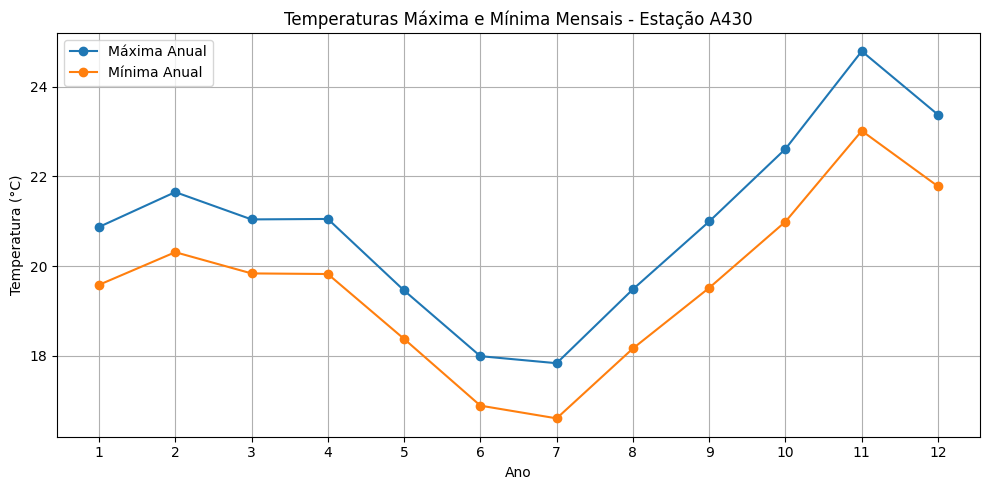

In [18]:
# Filtrar os dados apenas para a estação A305
dados_A305 = df_imputed[df_imputed['id_estacao'] == 'A430']

# Agrupar por ano e calcular a temperatura máxima e mínima anual
temperatura_anual = dados_A305.groupby('mes').agg(
    temperatura_max=('temperatura_max', 'mean'),
    temperatura_min=('temperatura_min', 'mean')
).reset_index()

# Plotar a série temporal anual
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['mes'], temperatura_anual['temperatura_max'], label='Máxima Anual', marker='o')
plt.plot(temperatura_anual['mes'], temperatura_anual['temperatura_min'], label='Mínima Anual', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Mensais - Estação A430')
plt.xticks(range(temperatura_anual['mes'].min(), temperatura_anual['mes'].max() + 1))  # Define os ticks do eixo x para cada ano
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Processo para todos os anos

In [19]:
# Lista das colunas alvo
target_columns = [
    'temperatura_max',
    'temperatura_min'
]

# Lista de anos que deseja processar
years = [2003,2004,2005,2006,2007,2008,
        2009,2010,2011,2012,2013,2014,2015,2016,2017,
        2018,2019,2020,2021,2022]

for year in years:
    # Recuperando os dados das estações para o ano específico
    df_meta_dados = fetch_inmet_data([year])
    
    if not df_meta_dados.empty:
        # Executar o pipeline
        df_imputed = run_pipeline(df_meta_dados, target_columns)
       
        # Salvar o dataset com valores imputados
        file_path = f'../dados/estacoes/dataset_imputed_{year}.csv'
        df_imputed.to_csv(file_path, index=False)
        print(f"Dataset imputed para {year} salvo com sucesso em {file_path}")
    else:
        print(f"Nenhum dado encontrado para o ano de {year}. O pipeline não foi executado.")

Downloading: 100%|██████████| 46848/46848 [00:13<00:00, 3359.76rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08170740902568654
Mean Absolute Error: 0.1994066968401358
R² Score: 0.9944178441185013
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.04810603772953429
Mean Absolute Error: 0.15716938799632388
R² Score: 0.9960246427635095
Remaining missing values in temperatura_min: 0
Dataset imputed para 2003 salvo com sucesso em ../dados/estacoes/dataset_imputed_2003.csv


Downloading: 100%|██████████| 54816/54816 [00:16<00:00, 3318.77rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09444953587348869
Mean Absolute Error: 0.20790706348968324
R² Score: 0.9934423145809169
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.04541771465549464
Mean Absolute Error: 0.13907170103516092
R² Score: 0.9962955056785501
Remaining missing values in temperatura_min: 0
Dataset imputed para 2004 salvo com sucesso em ../dados/estacoes/dataset_imputed_2004.csv


Downloading: 100%|██████████| 70080/70080 [00:21<00:00, 3309.08rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.0941943777338905
Mean Absolute Error: 0.2213234341662863
R² Score: 0.9956918829029379
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08504887688498985
Mean Absolute Error: 0.19542847321393822
R² Score: 0.9953934557766565
Remaining missing values in temperatura_min: 0
Dataset imputed para 2005 salvo com sucesso em ../dados/estacoes/dataset_imputed_2005.csv


Downloading: 100%|██████████| 70320/70320 [00:22<00:00, 3079.87rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09852183822556
Mean Absolute Error: 0.22552885657587077
R² Score: 0.9946601075082016
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08445456383132657
Mean Absolute Error: 0.21711871793699833
R² Score: 0.9947984225843645
Remaining missing values in temperatura_min: 0
Dataset imputed para 2006 salvo com sucesso em ../dados/estacoes/dataset_imputed_2006.csv


Downloading: 100%|██████████| 192696/192696 [00:58<00:00, 3303.09rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08873880796285995
Mean Absolute Error: 0.21775723476118916
R² Score: 0.9960931707134696
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.07519174929346394
Mean Absolute Error: 0.20422389427534254
R² Score: 0.9964461451801994
Remaining missing values in temperatura_min: 0
Dataset imputed para 2007 salvo com sucesso em ../dados/estacoes/dataset_imputed_2007.csv


Downloading: 100%|██████████| 498720/498720 [02:37<00:00, 3165.57rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08426627335975889
Mean Absolute Error: 0.2135390348597833
R² Score: 0.9960504339918405
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.07820124649111185
Mean Absolute Error: 0.2069289393560396
R² Score: 0.996106074422567
Remaining missing values in temperatura_min: 0
Dataset imputed para 2008 salvo com sucesso em ../dados/estacoes/dataset_imputed_2008.csv


Downloading: 100%|██████████| 610536/610536 [03:54<00:00, 2599.18rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08346971746290646
Mean Absolute Error: 0.20427110393205833
R² Score: 0.9956382453206089
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.07377984276374111
Mean Absolute Error: 0.1986845825189458
R² Score: 0.9957158721787006
Remaining missing values in temperatura_min: 0
Dataset imputed para 2009 salvo com sucesso em ../dados/estacoes/dataset_imputed_2009.csv


Downloading: 100%|██████████| 624792/624792 [03:14<00:00, 3213.49rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.0860647230672066
Mean Absolute Error: 0.2098964042005382
R² Score: 0.9959206429724904
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08054280310516228
Mean Absolute Error: 0.20473287310830937
R² Score: 0.9958357967270861
Remaining missing values in temperatura_min: 0
Dataset imputed para 2010 salvo com sucesso em ../dados/estacoes/dataset_imputed_2010.csv


Downloading: 100%|██████████| 639480/639480 [03:07<00:00, 3406.33rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08642402585989742
Mean Absolute Error: 0.2129101678703746
R² Score: 0.9955829552109999
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08012281473843334
Mean Absolute Error: 0.20624702791614846
R² Score: 0.9955026384735972
Remaining missing values in temperatura_min: 0
Dataset imputed para 2011 salvo com sucesso em ../dados/estacoes/dataset_imputed_2011.csv


Downloading: 100%|██████████| 641232/641232 [03:18<00:00, 3237.25rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08728600544978109
Mean Absolute Error: 0.21545840943647898
R² Score: 0.9960457483329067
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.07901465042452155
Mean Absolute Error: 0.207031764738866
R² Score: 0.9961512026691903
Remaining missing values in temperatura_min: 0
Dataset imputed para 2012 salvo com sucesso em ../dados/estacoes/dataset_imputed_2012.csv


Downloading: 100%|██████████| 639480/639480 [03:18<00:00, 3229.24rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08137277386492238
Mean Absolute Error: 0.20979469506127865
R² Score: 0.9960102939515522
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.07735479160677876
Mean Absolute Error: 0.2054145097498081
R² Score: 0.9959173418864568
Remaining missing values in temperatura_min: 0
Dataset imputed para 2013 salvo com sucesso em ../dados/estacoes/dataset_imputed_2013.csv


Downloading: 100%|██████████| 639480/639480 [03:14<00:00, 3283.43rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08310034763641422
Mean Absolute Error: 0.2121049948683468
R² Score: 0.9957600882925188
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08111488504213052
Mean Absolute Error: 0.2110013189902102
R² Score: 0.9955620937598578
Remaining missing values in temperatura_min: 0
Dataset imputed para 2014 salvo com sucesso em ../dados/estacoes/dataset_imputed_2014.csv


Downloading: 100%|██████████| 646080/646080 [03:21<00:00, 3207.83rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09021405747803754
Mean Absolute Error: 0.22045644078178686
R² Score: 0.9959591477301653
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.0863099436861769
Mean Absolute Error: 0.2181198450113135
R² Score: 0.9958991039821469
Remaining missing values in temperatura_min: 0
Dataset imputed para 2015 salvo com sucesso em ../dados/estacoes/dataset_imputed_2015.csv


Downloading: 100%|██████████| 676128/676128 [03:49<00:00, 2952.33rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08690736377114688
Mean Absolute Error: 0.21595173283980232
R² Score: 0.9958187129377444
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08216107187982226
Mean Absolute Error: 0.21276635657518939
R² Score: 0.995829217314041
Remaining missing values in temperatura_min: 0
Dataset imputed para 2016 salvo com sucesso em ../dados/estacoes/dataset_imputed_2016.csv


Downloading: 100%|██████████| 712656/712656 [03:46<00:00, 3143.43rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08741241315201519
Mean Absolute Error: 0.21525495514193815
R² Score: 0.995916955430053
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08262722560216754
Mean Absolute Error: 0.2141368937881087
R² Score: 0.9958605268001943
Remaining missing values in temperatura_min: 0
Dataset imputed para 2017 salvo com sucesso em ../dados/estacoes/dataset_imputed_2017.csv


Downloading: 100%|██████████| 760968/760968 [03:45<00:00, 3379.04rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08605900035493237
Mean Absolute Error: 0.21516740591064643
R² Score: 0.9956954823014755
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08388075268508095
Mean Absolute Error: 0.21535889919504655
R² Score: 0.9955685375371027
Remaining missing values in temperatura_min: 0
Dataset imputed para 2018 salvo com sucesso em ../dados/estacoes/dataset_imputed_2018.csv


Downloading: 100%|██████████| 762120/762120 [03:41<00:00, 3446.81rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09545303264605934
Mean Absolute Error: 0.22481016704172296
R² Score: 0.995550899319246
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09348717517017449
Mean Absolute Error: 0.22002354938718094
R² Score: 0.9953476970213795
Remaining missing values in temperatura_min: 0
Dataset imputed para 2019 salvo com sucesso em ../dados/estacoes/dataset_imputed_2019.csv


Downloading: 100%|██████████| 764208/764208 [03:15<00:00, 3904.27rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09103143121099756
Mean Absolute Error: 0.21964235043436514
R² Score: 0.9952065562282222
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09166595134360976
Mean Absolute Error: 0.22463868483343621
R² Score: 0.994862279441683
Remaining missing values in temperatura_min: 0
Dataset imputed para 2020 salvo com sucesso em ../dados/estacoes/dataset_imputed_2020.csv


Downloading: 100%|██████████| 762120/762120 [02:55<00:00, 4334.62rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09327755327909543
Mean Absolute Error: 0.22194654378900808
R² Score: 0.9952300396531101
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.0947761211290445
Mean Absolute Error: 0.23024535766774362
R² Score: 0.994856603722581
Remaining missing values in temperatura_min: 0
Dataset imputed para 2021 salvo com sucesso em ../dados/estacoes/dataset_imputed_2021.csv


Downloading: 100%|██████████| 753360/753360 [02:55<00:00, 4293.78rows/s]


Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.0921273879755725
Mean Absolute Error: 0.22151763115486287
R² Score: 0.9952645396005672
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09645003742710717
Mean Absolute Error: 0.22911241996630102
R² Score: 0.9947651877975902
Remaining missing values in temperatura_min: 0
Dataset imputed para 2022 salvo com sucesso em ../dados/estacoes/dataset_imputed_2022.csv
